<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/lsun_diffusion_latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate
!pip install einops

In [1]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os
# import lpips

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st
from accelerate import Accelerator
from datasets import load_dataset
from einops import rearrange

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
# from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Latent Prep

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz
!tar xvf bedroom.tgz

In [ ]:
path = Path('./bedroom')

In [ ]:
from glob import glob

In [ ]:
files = out = glob(str(path/f'**/*.jpg'), recursive = True)

In [ ]:
from torchvision.io import read_image, ImageReadMode
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [ ]:
class LS_setup_ds:
  def __init__(self, files = files):
    self.files = files

  def __getitem__(self, idx):
    fp = self.files[idx]
    return (read_image(fp, mode = ImageReadMode.RGB)/255)[:, :256, :256], 1.

  def __len__(self): return len(self.files)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds = LS_setup_ds()
dl = DataLoader(ds, batch_size = 64)

In [ ]:
latents = []

In [ ]:
# vae = vae.cuda()
for x, y in tqdm(dl):
  latents.append(vae.encode(x.cuda()).latent_dist.mean.cpu())

In [ ]:
len(latents)

579

In [ ]:
lats = torch.cat(latents, dim = 0)

In [ ]:
lats.shape

torch.Size([37056, 4, 32, 32])

In [ ]:
mdl_path

Path('drive/MyDrive/fastai_p2/models')

In [ ]:
pat = mdl_path/'lsun/data'
pat.mkdir(parents = True)

In [ ]:
torch.save(lats, pat/'latents.pkl')

In [ ]:
with open(pat/'latents_new.pkl', 'wb') as f:
  pickle.dump(lats, f)

In [ ]:
with open(pat/'latents_new.pkl', 'rb') as f:
  nns = pickle.load(f)

In [ ]:
nns.shape

torch.Size([37056, 4, 32, 32])

In [ ]:
nns.device

device(type='cpu')

# Latent Diffusion

In [2]:
from torchvision.io import read_image, ImageReadMode
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").requires_grad_(False).cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
path = mdl_path/'lsun/data/latents_new.pkl'

In [4]:
with open(path, 'rb') as f:
  ts = pickle.load(f)

mean, std = ts.mean((0, 2, 3)), ts.std((0, 2, 3))
def normalize(x):
  return (x - mean[None, :, None, None])/std[None, :, None, None]

In [5]:
class LSDS:
  def __init__(self, ts):
    self.ts = ts

  def __getitem__(self, idx):
    x = self.ts[idx]
    return x, x

  def __len__(self):
    return self.ts.shape[0]

In [6]:
train_ds, valid_ds = LSDS(ts[:30000]), LSDS(ts[30000:])
train_dl, valid_dl = DataLoader(train_ds, batch_size = 128, shuffle = True), DataLoader(valid_ds, batch_size = 128, shuffle = True)

In [10]:
x, y = next(iter(train_dl))
x = normalize(x)

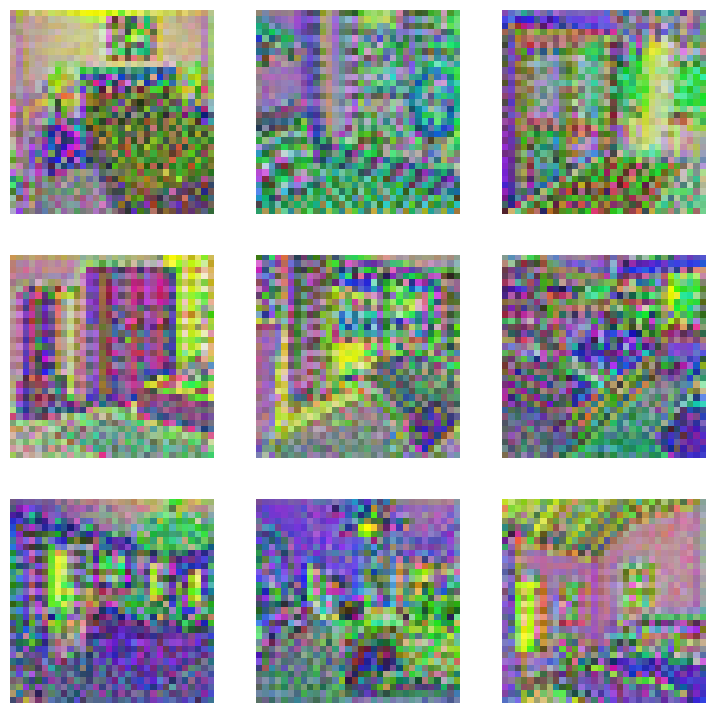

In [11]:
nx = x[:, :3, :, :]
show_images((nx[:9]).sigmoid())

In [7]:
def flatten_mse(yhat, targ): return F.mse_loss(yhat.flatten(), targ.flatten())

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class LatentDDPMPrep(DDPMPrep):
  def before_batch(self, learn):
    x = normalize(learn.batch[0])
    learn.batch = noisify_img(self, x)

class ConditionalDDPMPrep(DDPMPrep):

  def before_batch(self, learn):

    x, label = learn.batch
    (ox, ts), ys = noisify_img(self, learn.batch[0])
    learn.batch = ((ox, ts, label), ys)

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def _pre_conv(ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni))
  layers.append(nn.Conv2d(ni, nf, kernel_size, stride = stride, padding = kernel_size//2, bias = True))
  return nn.Sequential(*layers)

class ResBlock(nn.Module):
  def __init__(self, ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
    super().__init__()
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.convs = nn.Sequential(
        _pre_conv(ni, nf, kernel_size, 1, act, norm),
        _pre_conv(nf, nf, kernel_size, stride, act, norm)
    )

  def forward(self, x): return self.id_conv(x) + self.convs(x)

class SM:
  def forward(self, *args, **kwargs):
    self.saved = super().forward(*args, **kwargs)
    return self.saved

class SConv(SM, nn.Conv2d): pass
class SResBlock(SM, ResBlock): pass

def get_tembs(nsteps, nemb = 32, max_steps = 1000):
  tsteps = torch.linspace(-10, 10, nsteps)
  points = -1*math.log(max_steps) * torch.linspace(0, 1, nemb//2)
  points_dist = tsteps[:, None] * points[None, :].exp()
  return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

class SelfAttention(nn.Module):
  def __init__(self, ni):
    super().__init__()
    self.kqv = nn.Linear(ni, 3*ni)
    self.norm = nn.GroupNorm(1, ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = ni

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      return rearrange(x, 'b c h w -> b (h w) c')
    if mode == 2:
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # Verify Shape
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return inp + x

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    ni = ni//n_heads
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return x

class MultiHeadSelfAttentionV2(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    x = inp
    x = self.norm(x)

    h, w = x.shape[-2], x.shape[-1]

    x = rearrange(x, 'b c h w -> b (h w) c')
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    k = rearrange(k, 'b s (c d) -> (b d) s c', d = self.n_heads)
    q = rearrange(q, 'b s (c d) -> (b d) s c', d = self.n_heads)
    v = rearrange(v, 'b s (c d) -> (b d) s c', d = self.n_heads)

    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    att_x = rearrange(att_x, '(b d) s c -> b s (c d)', d = self.n_heads)
    x = self.proj(att_x)
    out = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
    return out

class AttEmbResBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.emb_proj = nn.Linear(n_emb, 2*nf)
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.conv1 = _pre_conv(ni, nf, kernel_size, 1, act, norm)
    self.conv2 = _pre_conv(nf, nf, kernel_size, stride, act, norm)
    if attn: self.attn = MultiHeadSelfAttentionV2(nf, 8)

  def forward(self, x, t_emb):
    res = self.conv1(x)
    t_emb = self.emb_proj(t_emb)[:, :, None, None]  # bs, 2*nf
    scale, shift = t_emb.chunk(2, dim = 1)
    res = res + res * scale + shift
    res = self.conv2(res)
    x = self.id_conv(x) + res
    if hasattr(self, 'attn'): x = x + self.attn(x)
    return x

class SAttEmbResBlock(SM, AttEmbResBlock): pass

class DownBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.layers = nn.ModuleList([SAttEmbResBlock(ni if i == 0 else nf, nf, n_emb = n_emb, act = act, norm = norm, attn = attn) for i in range(n_layers)])
    self.f_layer = SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1) if add_down == True else fc.noop

  def forward(self, x, t_emb):
    for layer in self.layers:
      x = layer(x, t_emb)
    return self.f_layer(x)

  def get_acts(self):
    acts = [l.saved for l in self.layers]
    if hasattr(self.f_layer, 'saved'): acts.append(self.f_layer.saved)
    return acts

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, n_emb, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(AttEmbResBlock(inc, nf, n_emb = n_emb, act = act, norm = norm, attn = attn))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups, t_emb):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1), t_emb)
    return self.up(x)

class DDIM_SchedulerV2: # This is only for sampling purposes

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def step(self, xt, np, cts, eta = 0.8):

    a_bar_t, a_bar_t_1 = self.noise_cb.alpha_bar[cts], self.noise_cb.alpha_bar[cts + 1] if cts > 0 else torch.tensor(1.)
    b_bar_t, b_bar_t_1 = (1. - a_bar_t), (1. - a_bar_t_1)

    if cts == 0: st()

    x0_hat = (xt - b_bar_t_1.sqrt()*np)/(a_bar_t.sqrt())

    # if cts == 0: return x0_hat

    sig = (b_bar_t/b_bar_t_1).sqrt() * (1. - (a_bar_t_1/a_bar_t)).sqrt() * eta

    xt = a_bar_t_1.sqrt()*x0_hat + (b_bar_t_1 - sig**2).sqrt()*np
    if cts > 0: xt += sig*torch.randn(xt.shape).to(xt.device)
    return xt

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev): return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step_new(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)

    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)


    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample_v3(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(LatentDDPMPrep(n_steps = 1000, beta_max = 0.01))):
  model.device = torch.device('cuda')
  sched.set_timesteps(n_steps, skips = 10)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    # print(np.mean(), np.std(), np.max(), np.min())
    xt = sched.step_new(xt, np, ts, eta = 0.8)
    # if ts%10 == 0: print(ts, xt.mean().item(), xt.std().item(), xt.max().item(), xt.min().item())
  return xt

In [8]:
class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = 4, out_channels = 4, nfs = [64, 128, 256, 512], n_layers = 2, emb_dim = 16, attn_start = 2):
    super().__init__()
    self.emb_dim = emb_dim
    n_emb = nfs[0]*4
    self.emb_mlp = nn.Sequential(nn.Linear(emb_dim, n_emb, bias = True),
                                 nn.BatchNorm1d(n_emb),
                                 nn.Linear(n_emb, n_emb, bias = True))

    # self.c_emb = nn.Embedding(n_classes, n_emb)

    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(DownBlock(ni, nf, n_emb = n_emb, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True, attn = True if i >= attn_start else False))
      ni = nf

    self.downs = nn.Sequential(*downs)

    cross = [AttEmbResBlock(nfs[0], nfs[0], n_emb = n_emb, attn = False)]
    for i, cnf in enumerate(nfs):
      cross += [AttEmbResBlock(cnf, cnf, n_emb = n_emb, attn = True if i >= attn_start else False) for j in range(n_layers + 1 if i < len(nfs) - 1 else n_layers)]
    self.cross = nn.ModuleList(cross)

    self.mid_c = AttEmbResBlock(nf, nf, n_emb = n_emb, attn = True)

    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, n_emb = n_emb, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1, attn = True if i <= attn_start else False))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels) # EmbResBlock(nf, nf, n_emb = n_emb)

  def forward(self, inp):
    x, ts = inp

    tembs = get_tembs(1000, self.emb_dim).to(x.device)[ts]

    t_emb = self.emb_mlp(tembs) # bs, 4*nfs[0]
    # c_emb = self.c_emb(ys)
    emb = t_emb #+ c_emb
    x = self.first_c(x)
    acts = [x]
    for block in self.downs:
      x = block(x, emb)
    x = self.mid_c(x, emb)
    # acts += [i.saved for j in self.downs for i in j]
    for i in self.downs: acts += i.get_acts()
    n_acts = [cr(act, emb) for cr, act in zip(self.cross, acts)]
    for up in self.ups: x = up(x, n_acts, emb)
    return self.final_c(x)


In [16]:
cb_obj = LatentDDPMPrep(beta_max = 0.01)
x, y = next(iter(train_dl))
(xt, ts), noise = noisify_img(cb_obj, normalize(x))

In [17]:
xt.shape

torch.Size([128, 4, 32, 32])

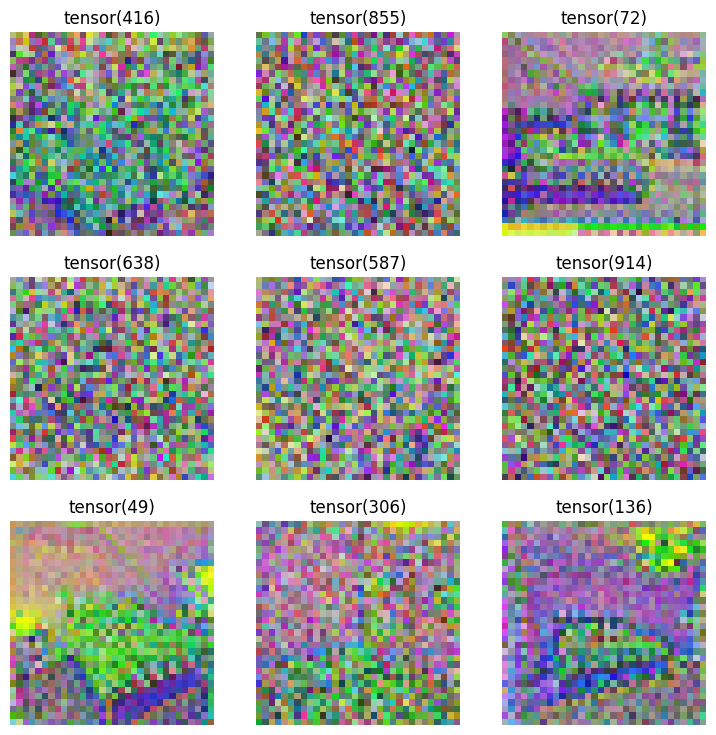

In [18]:
show_images(torch.sigmoid(xt[:9, :3, :, :]), titles = [str(i) for i in ts[:9]])

In [9]:
def denorm(x):
  return x*std[None, :, None, None] + mean[None, :, None, None]

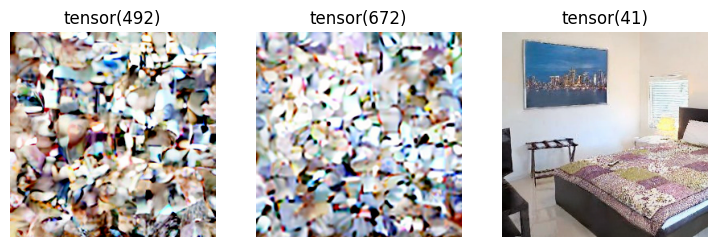

In [ ]:
dec = vae.decode(denorm(xt[-3:])).sample
show_images(dec, titles = [str(i) for i in ts[-3:]])

In [20]:
model = DiffusionUNET(n_layers = 1)

In [10]:
mean = mean.cuda()
std = std.cuda()

loss,epoch,train
0.453,0,train
0.335,0,eval
0.318,1,train
0.296,1,eval
0.289,2,train
0.285,2,eval
0.276,3,train
0.286,3,eval
0.270,4,train
0.264,4,eval


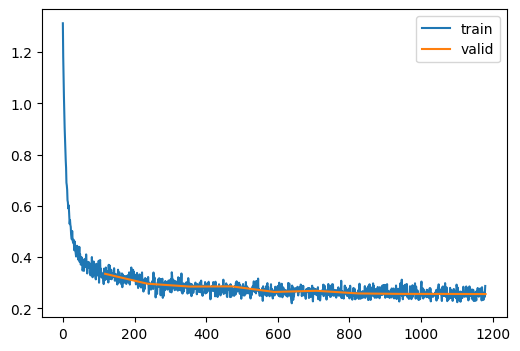

In [23]:
lr_max, epochs = 2e-03, 10
train_dl, valid_dl = DataLoader(train_ds, batch_size = 256, shuffle = True), DataLoader(valid_ds, batch_size = 256, shuffle = True)
dls = DataLoaders(train_dl, valid_dl)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          LatentDDPMPrep(n_steps = 1000, beta_max=0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [24]:
torch.save(learner.model, mdl_path/'latent_diff_lsun_v1.pkl')

In [25]:
class DDIM_SchedulerV2: # This is only for sampling purposes

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def step(self, xt, np, cts, eta = 0.8):

    a_bar_t, a_bar_t_1 = self.noise_cb.alpha_bar[cts], self.noise_cb.alpha_bar[cts + 1] if cts > 0 else torch.tensor(1.)
    b_bar_t, b_bar_t_1 = (1. - a_bar_t), (1. - a_bar_t_1)

    if cts == 0: st()

    x0_hat = (xt - b_bar_t_1.sqrt()*np)/(a_bar_t.sqrt())

    # if cts == 0: return x0_hat

    sig = (b_bar_t/b_bar_t_1).sqrt() * (1. - (a_bar_t_1/a_bar_t)).sqrt() * eta

    xt = a_bar_t_1.sqrt()*x0_hat + (b_bar_t_1 - sig**2).sqrt()*np
    if cts > 0: xt += sig*torch.randn(xt.shape).to(xt.device)
    return xt

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev): return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step_new(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)

    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)


    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin'):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

def ddim_sample_v3(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(LatentDDPMPrep(n_steps = 1000, beta_max = 0.01))):
  model.device = torch.device('cuda')
  sched.set_timesteps(n_steps, skips = 10)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    # print(np.mean(), np.std(), np.max(), np.min())
    xt = sched.step_new(xt, np, ts, eta = 0.8)
    # if ts%10 == 0: print(ts, xt.mean().item(), xt.std().item(), xt.max().item(), xt.min().item())
  return xt

In [28]:
mout = ddim_sample_v3(learner.model, 1000, out_shape = (128, 4, 32, 32))

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


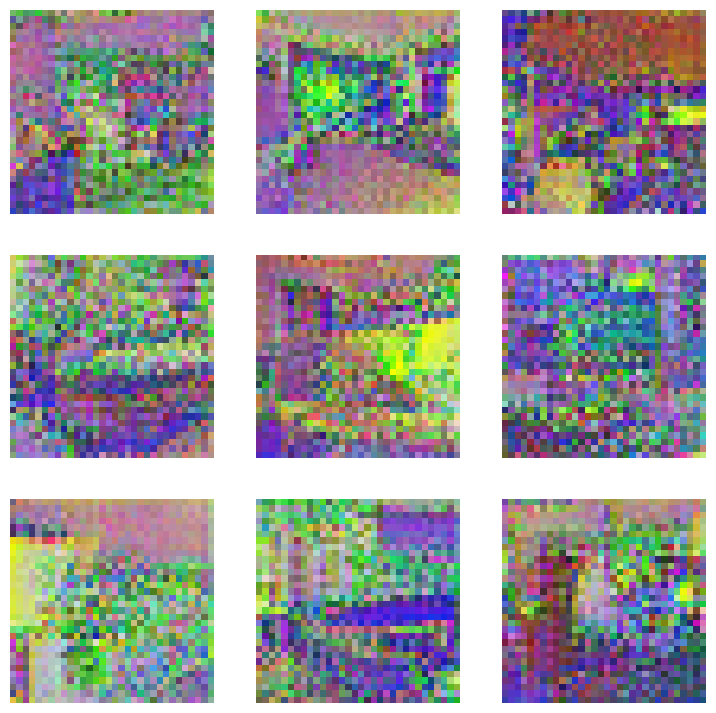

In [29]:
show_images(torch.sigmoid(mout[:9, :3, :, :]))

In [30]:
vae = vae.cuda()

In [ ]:
dnorm_mout = denorm(mout)
out = vae.decode(dnorm_mout[:16]).sample


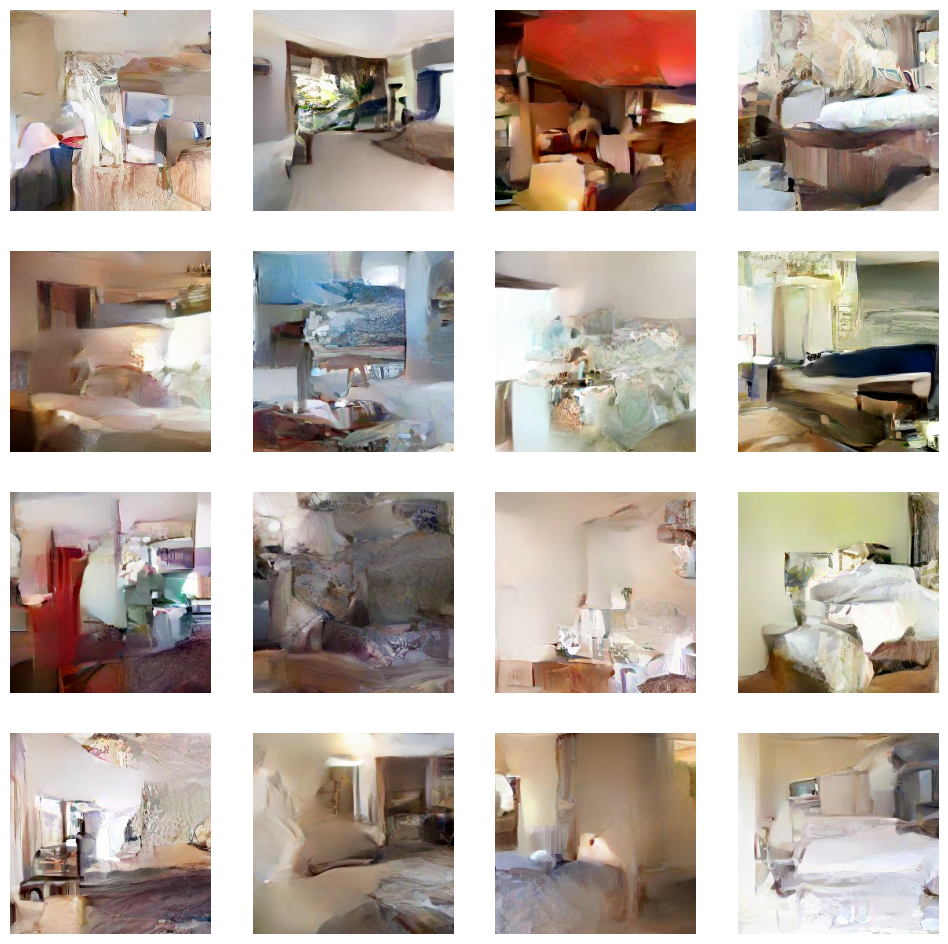

In [34]:
show_images(out, ncols = 4)

In [12]:
del vae
del model
del dls
del train_dl
del valid_dl
clean_mem()

In [14]:
torch.cuda.empty_cache()

loss,epoch,train
0.365,0,train
0.312,0,eval
0.297,1,train
0.282,1,eval
0.277,2,train
0.274,2,eval
0.264,3,train
0.278,3,eval
0.259,4,train
0.262,4,eval


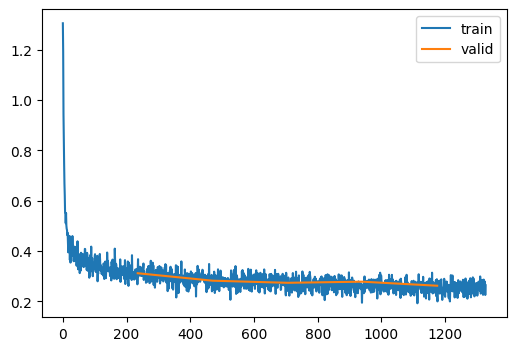

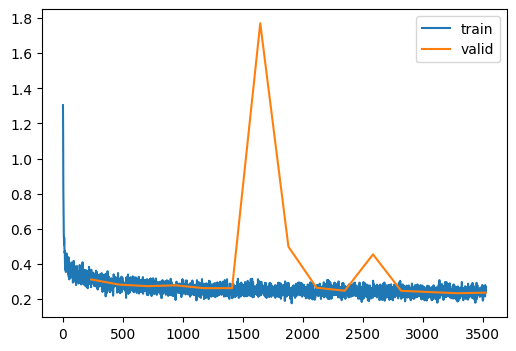

loss,epoch,train
0.365,0,train
0.312,0,eval
0.297,1,train
0.282,1,eval
0.277,2,train
0.274,2,eval
0.264,3,train
0.278,3,eval
0.259,4,train
0.262,4,eval


In [11]:
lr_max, epochs = 2e-03, 15
# train_dl, valid_dl = DataLoader(train_ds, batch_size = 128, shuffle = True), DataLoader(valid_ds, batch_size = 128, shuffle = True)
dls = DataLoaders(train_dl, valid_dl)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          LatentDDPMPrep(n_steps = 1000, beta_max=0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [128, 256, 512, 1024], n_layers=3)
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [12]:
torch.save(learner.model, mdl_path/'latent_diff_lsun_v2.pkl')

In [13]:
mout = ddim_sample_v3(learner.model, 1000, out_shape = (128, 4, 32, 32))

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


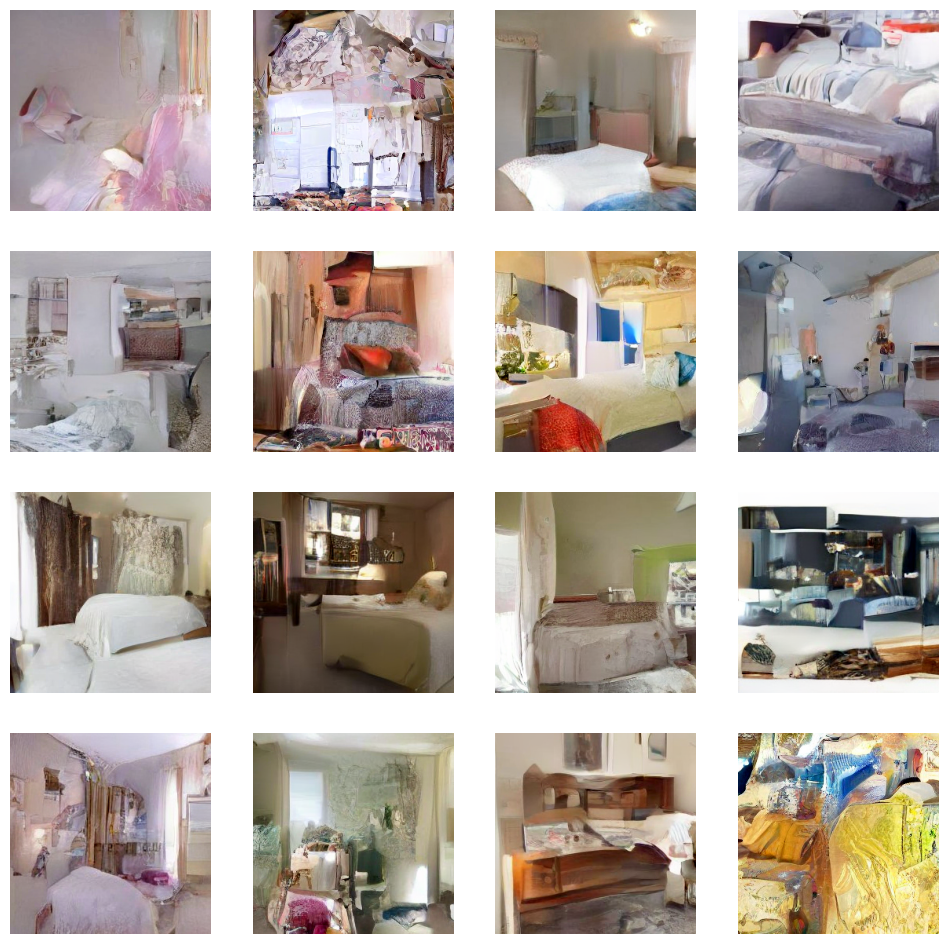

In [14]:
dnorm_mout = denorm(mout)
out = vae.decode(dnorm_mout[:16]).sample
show_images(out, ncols = 4)